In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [3]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [4]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

In [5]:
# bi_columns = ['num_var1_0', 'num_var1', 'num_var4', 'num_var5_0', 'num_var5',
#        'num_var8_0', 'num_var12', 'num_var13_0', 'num_var13_corto_0',
#        'num_var13_corto', 'num_var14', 'num_var24_0', 'num_var24',
#        'num_var32_0', 'num_var33_0', 'num_var40_0', 'num_var42',
#        'num_var44_0', 'num_sal_var16_ult1', 'num_var13_largo_0', 'num_var13', 'num_var33']

_d_df = X.describe().transpose()
cols = _d_df[(_d_df['max'] < 20) & (_d_df['max'] > 3)].index
for _c in cols:
    new_column_name = 'bi_'+_c
    X[new_column_name] = 0
    test[new_column_name] = 0
    
    X.loc[X[_c] > 0, new_column_name] = 1
    test.loc[test[_c] > 0, new_column_name] = 1

X = X.drop(cols, axis=1)
test = test.drop(cols, axis=1)

In [6]:
X['var38mc'] = np.isclose(X.var38, 117310.979016)
X['logvar38'] = X.loc[~X['var38mc'], 'var38'].map(np.log)
X.loc[X['var38mc'], 'logvar38'] = 0

test['var38mc'] = np.isclose(test.var38, 117310.979016)
test['logvar38'] = test.loc[~test['var38mc'], 'var38'].map(np.log)
test.loc[test['var38mc'], 'logvar38'] = 0

In [7]:
X = X.drop(['var38'], axis=1)
test = test.drop(['var38'], axis=1)

In [8]:
for f in X.columns:
    lim_min = np.min(X[f])
    test[test[f]<lim_min] = lim_min
  
    lim_max = np.max(X[f])
    test[test[f]>lim_max] = lim_max 

In [9]:
# for f in X.columns:
#     if np.max(X[f]) > 1000000 and np.min(X[f]) > 0:
#         X['log'+f] = X[f].map(np.log)
#         test['log'+f] = test[f].map(np.log)

In [10]:
X['log_saldo_medio_var5_hace3'] = X.loc[X['saldo_medio_var5_hace3']>0, 'saldo_medio_var5_hace3'].map(np.log)
X.loc[X['saldo_medio_var5_hace3']<=0, 'log_saldo_medio_var5_hace3'] = 0

test['log_saldo_medio_var5_hace3'] = test.loc[test['saldo_medio_var5_hace3']>0, 'saldo_medio_var5_hace3'].map(np.log)
test.loc[test['saldo_medio_var5_hace3']<=0, 'log_saldo_medio_var5_hace3'] = 0

In [11]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

features = X.columns[1:-1]
pca = PCA(n_components=2)

x_train_projected = pca.fit_transform(normalize(X[features], axis=0))
x_test_projected = pca.transform(normalize(test[features], axis=0))

X.insert(1, 'PCAOne', x_train_projected[:, 0])
X.insert(1, 'PCATwo', x_train_projected[:, 1])
test.insert(1, 'PCAOne', x_test_projected[:, 0])
test.insert(1, 'PCATwo', x_test_projected[:, 1])

In [12]:
features = X.columns[1:-1]
X.insert(1, 'SumZeros', (X[features] == 0).astype(int).sum(axis=1))
test.insert(1, 'SumZeros', (test[features] == 0).astype(int).sum(axis=1))

In [13]:
clf = ExtraTreesClassifier(random_state=1234)
selector = clf.fit(X, y)

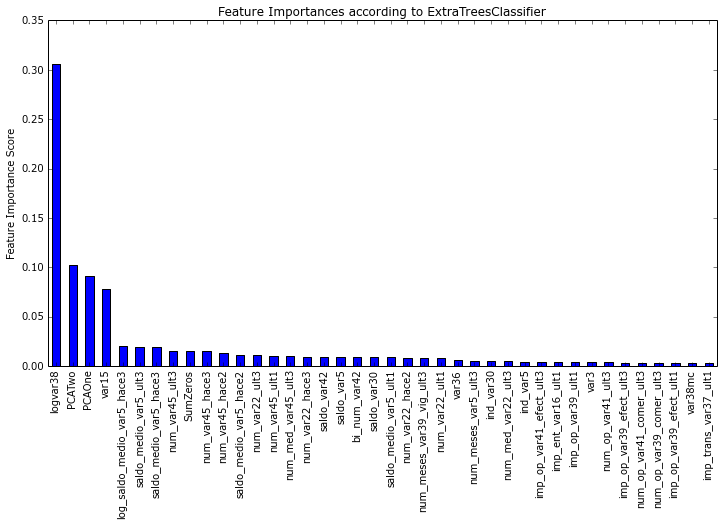

In [14]:
feat_imp = pd.Series(clf.feature_importances_, index = X.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.show()

In [15]:
fs = SelectFromModel(selector, prefit=True, threshold=0.00002)

X_select = fs.transform(X)
test_select = fs.transform(test)

print(X_select.shape, test_select.shape)

((76020, 198), (75818, 198))


In [16]:
feature_count = 204

# но отберем руками
not_important = filter(lambda x: x not in feat_imp[:feature_count].index, X.columns)
important = filter(lambda x: x in feat_imp[:feature_count].index, X.columns)

X_select = X.drop(not_important, axis=1).values
test_select = test.drop(not_important, axis=1).values

In [17]:
# топ-10 фич
X[feat_imp[:10].index].describe()

,logvar38,PCATwo,PCAOne,var15,log_saldo_medio_var5_hace3,saldo_medio_var5_ult3,saldo_medio_var5_hace3,num_var45_ult3,SumZeros,num_var45_hace3
count,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000
mean,9.199169,-1.044519e-17,-2.022011e-16,33.212865,1.416458,1048.856447,8.913659e+02,13.651105,273.664128,3.894396
std,4.569727,1.428682e-02,1.700207e-02,12.956486,2.512596,8189.948852,9.888597e+03,33.304012,17.345697,10.416821
min,0.000000,-4.041161e-01,-7.852580e-03,5.000000,-3.506558,-476.070000,-8.040000e+00,0.000000,165.000000,0.000000
25%,10.602061,3.073861e-03,-6.885568e-03,23.000000,0.000000,0.000000,0.000000e+00,0.000000,263.000000,0.000000
50%,11.221319,3.459086e-03,-6.521589e-03,28.000000,0.000000,2.730000,9.900000e-01,0.000000,278.000000,0.000000
75%,11.684828,4.063937e-03,-8.265071e-04,40.000000,2.502869,83.790000,1.221750e+01,12.000000,286.000000,3.000000
max,16.908131,8.343805e-02,3.167478e-01,105.000000,14.248811,544365.570000,1.542339e+06,801.000000,299.000000,339.000000


In [18]:
# num_var4

In [19]:
# xgb.XGBClassifier(n_estimators=100, nthread=-1, max_depth = 4, seed=1234,
#                            learning_rate=0.05, subsample = 0.6815, colsample_bytree = 0.701)
fxgb = lambda: xgb.XGBClassifier(n_estimators=100, nthread=-1, max_depth = 4, seed=1234,
                           learning_rate=0.05, subsample = 0.7, colsample_bytree = 0.701)

fxgb1 = lambda: xgb.XGBClassifier(n_estimators=100, nthread=-1, max_depth = 4, seed=1234,
                       learning_rate=0.05, subsample = 0.7, colsample_bytree = 0.701)
fxgb2 = lambda: xgb.XGBClassifier(n_estimators=80, nthread=-1, max_depth = 6, seed=1234,
                       learning_rate=0.05, subsample = 0.7, colsample_bytree = 0.701)
fxgb3 = lambda: xgb.XGBClassifier(n_estimators=120, nthread=-1, max_depth = 5, seed=1234,
                       learning_rate=0.1, subsample = 1, colsample_bytree = 0.701)

In [24]:
def model_score(model_name, train, target):
    """
    train: np.Array
    """    
    skf = StratifiedKFold(target, n_folds=4, random_state=1234)
    scores = []
    
    for train_index, test_index in skf:

        if model_name == 'xgb':
            model = fxgb()
        else:
            raise Exception('invalid model')
        
        ROCtrainTRN, ROCtestTRN = train[train_index], train[test_index]
        ROCtrainTRG, ROCtestTRG = target[train_index], target[test_index]

        model.fit(ROCtrainTRN, ROCtrainTRG)
        probas = model.predict_proba(ROCtestTRN)
        _score = roc_auc_score(ROCtestTRG, probas[:,1], average='macro')
        print("Roc AUC: {}".format(_score))
        scores.append(_score)
        
    return np.array(scores).mean()

In [27]:
def ensembly_score(train, target):
    skf = StratifiedKFold(target, n_folds=4, random_state=1234)
    scores = []
    for train_index, test_index in skf:
        models = [fxgb1(), fxgb2(), fxgb3()]
        ROCtrainTRN, ROCtestTRN = train[train_index], train[test_index]
        ROCtrainTRG, ROCtestTRG = target[train_index], target[test_index]
        results = None
        for model in models:
            model.fit(ROCtrainTRN, ROCtrainTRG)
            probas = model.predict_proba(ROCtestTRN)
            if results is None:
                results = probas[:,1]
            else:
                results = np.column_stack([probas[:,1], results])
        probas = np.mean(results, axis=1)
        _score = roc_auc_score(ROCtestTRG, probas, average='macro')
        print("Roc AUC: {}".format(_score))
        scores.append(_score)
    return np.array(scores).mean()

In [28]:
# 0.837782486756
# 0.839675737142 0.837590
print(ensembly_score(X.values, y))

Roc AUC: 0.83151662041
Roc AUC: 0.837008285435
Roc AUC: 0.848177500114
Roc AUC: 0.84200054261
0.839675737142


In [29]:
# 0.837887097022 0.835513
print(model_score('xgb', X.values, y))

Roc AUC: 0.829806030137
Roc AUC: 0.835252089135
Roc AUC: 0.846328161153
Roc AUC: 0.84036885222
0.837938783161


In [ ]:
# 0.828082874938 
# print(model_score('xgb', fs.transform(X), y))

In [ ]:
# xgb_model = fxgb()
# xgb_model.fit(X.values, y)
# probs = xgb_model.predict_proba(test.values)
# pred = probs[:,1]

In [30]:
models = [fxgb1(), fxgb2(), fxgb3()]
results = None
for model in models:
    model.fit(X.values, y)
    probas = model.predict_proba(test.values)
    if results is None:
        results = probas[:,1]
    else:
        results = np.column_stack([probas[:,1], results])
pred = np.mean(results, axis=1)

In [31]:
submission = pd.DataFrame({"ID":test_id, "TARGET": pred})
submission.to_csv("submission_stack_xgb.csv", index=False)